# PageRank

Page Rank se inspira en el modelo **Random Surfers**



#### Librerías utilizadas

In [2]:
import numpy as np
import math
import pandas as pd
# Para las pruebas
from pytest import approx
import pprint
# Para los grafos
import networkx as nx
import matplotlib.pyplot as plt

## Definimos un grafo pequeño

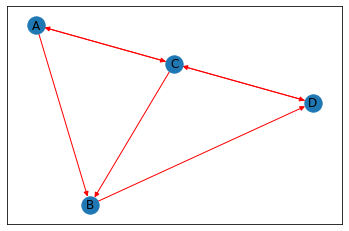

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

nodos = ['A', 'B', 'C', 'D']

G = nx.DiGraph()

for nodo in nodos:
    G.add_node(nodo)
    

G.add_edge("A","C")
G.add_edge("C","A")
G.add_edge("A","B")
G.add_edge("C","B")
G.add_edge("B","D")
G.add_edge("C","D")
G.add_edge("D","C")

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows = True)

plt.show()

### Definimos nuestra matriz estocástica conforme a lo visto en el grafo:

In [117]:
H = np.array([[0, 0, 1/3, 0],
              [1/2, 0, 1/3, 0],
              [1/2, 0, 0, 1], 
              [0, 1, 1/3, 0]
             ])

pprint.pprint(pd.DataFrame(H))

     0    1         2    3
0  0.0  0.0  0.333333  0.0
1  0.5  0.0  0.333333  0.0
2  0.5  0.0  0.000000  1.0
3  0.0  1.0  0.333333  0.0


## Aplicamos GoogleMatrix

La matriz que regresa la función representa la matriz de transición que describe la cadena de Markov utilizada en PageRank. Para que el PageRank converga a una única solución, la matriz de transición debe de ser irreducible y estocástica. En otras palabras, Debe existir un camino entre cada uno de los nodos en el grafo, ---or else there is the potential of “rank sinks.”---

Esta función trabaja con Multi(Di)Graphs. Para multigraphs el peso entre dos nodos debe ser la suma de todos los pesos de los edges entre esos nodos.

In [22]:
from networkx.algorithms.link_analysis.pagerank_alg import google_matrix

In [26]:
matrix = google_matrix(G, nodelist=nodos)

In [40]:
A = matrix.T

In [41]:
A

matrix([[0.0375    , 0.0375    , 0.32083333, 0.0375    ],
        [0.4625    , 0.0375    , 0.32083333, 0.0375    ],
        [0.4625    , 0.0375    , 0.0375    , 0.8875    ],
        [0.0375    , 0.8875    , 0.32083333, 0.0375    ]])

## Lo probamos con QR (el que realizamos en la práctica 2)

In [32]:
def sign(x):
    """
    Helper function for computing sign of real number x.
    """
    if x >= 0:
        return 1
    else:
        return -1

In [35]:
def inverse_matrix(A):
    """
    Helper function for computing the inverse of matrix A nxn.
    """
    inv_temp = []
    
    for i in range (0,A.shape[0]): 
        e1 = np.zeros((A.shape[0],1))
        e1[i] = 1
        A_inv_i = np.linalg.solve(A.T, e1)
        inv_temp.append(A_inv_i)  
        
    for j in range (0,len(inv_temp)-1):
        if j == 0:
            r_inv = np.row_stack((inv_temp[j].T, inv_temp[j+1].T))
        else:
            r_inv = np.row_stack((r_inv, inv_temp[j+1].T))
        
    return(r_inv)

In [57]:
def off(T):
    """
    Helper function for computing off(T).
    """
    mask = np.ones(T.shape, dtype = bool)
    np.fill_diagonal(mask, 0)
    T_sin_dig = T[mask]
    sum = 0
    for i in range (0,len(T_sin_dig)):
        print (T_sin_dig[i])
        sum += T_sin_dig[i]**2
    off_T = np.sqrt(sum)
    
    return(off_T)

In [53]:
def QR_Householder(A):
    """
    Decompose a real square matrix A where: A = QR usign Householder reflections.
    Args:
        A (numpy ndarray): Matrix in which QR algorithm will be performed.
    Returns:
        Q (numpy ndarray): orthogonal matrix (its columns are orthogonal unit vectors meaning 
                           Q.T*Q = Q*Q.T = I)
        R (numpy ndarray): upper triangular matrix.
    """
        
    a_aux = []
            
    for j in range (0,A.shape[0]-1):          #Asumimos que A SIEMPRE será cuadrada
        e = np.zeros((A.shape[0]-j, 1))
        e[0] = 1
        if j == 0:
            v = A[:,0] + sign(A[0,0])*np.linalg.norm(A[:,0])*e.T[0]
            beta = 2/v.dot(v)
            aux = A[:,0:] - beta*np.outer(v,v.dot(A[:,0:]))
            a_aux.append(aux)
        else:
            v = aux[1:,1] + sign(aux[1,1])*np.linalg.norm(aux[1:,1])*e.T[0]
            beta = 2/v.dot(v)  
            aux = aux[1:,1:] - beta*np.outer(v,v.dot(aux[1:,1:]))
            a_aux.append(aux)
        
    n,n = A.shape
    count = 0
    
    if n == 2:
        R = a_aux[0]
    else:
        for h in range(n-2,0,-1):
            if count == 0:
                temp_col = np.column_stack((np.zeros(2 + count), a_aux[h]))
            else:
                temp_col = np.column_stack((np.zeros(2 + count), temp_row))
            temp_row = np.row_stack((a_aux[h-1][0, 0:], temp_col))
            count += 1
        R = temp_row
    R_inv = inverse_matrix(R)
    
    Q = A@R_inv   

    return (Q,R)

In [54]:
def Eig_Householder(A):
    """
    Compute QR algorithm usign Householder reflections multiple times to approximate eigenvalues and 
    eigenvectors of A.
    Args:
        A (numpy ndarray): Symmetric matrix 
    Returns:
        evalues (numpy ndarray): Array with eigenvalues of matrix A.
        evectors (numpy ndarray): Matrix with eigenvectors of matrix A on its columns.
    """
    tol = 10e-8
    max_iters = 1000
    tk_fro_norm = np.linalg.norm(A, 'fro')
    iterations = 0
    off_Tk = off(A)
    
    q_aux = []
    
    while off_Tk > tol*tk_fro_norm and iterations < max_iters:
        iterations += 1
        if iterations == 1:
            Tk_minus1 = A
        else:
            Tk_minus1 = Tk
        
        q,r = QR_Householder(Tk_minus1)    
        q_aux.append(q)
        
        Tk = r@q
        
        off_Tk = off(Tk)
        tk_fro_norm = np.linalg.norm(Tk, 'fro')
    
    #Multiplicación Q0*Q1...Qn para cálculo de eigenvectores
    for g in range(0,len(q_aux)-1,1):
        if g == 0:
            q_temp = q_aux[g]@q_aux[g+1]
        else:
            q_temp = q_temp@q_aux[g+1]
    
    if iterations == 0:
        evalues = "error"
        evectors = "error"
    else:
        evectors = q_temp
        evalues = np.diag(Tk)
    
    return (evalues,evectors)

In [55]:
q,r = QR_Householder(A)

ValueError: shapes (4,4) and (16,16) not aligned: 4 (dim 1) != 16 (dim 0)

In [58]:
eigval, eigvec = Eig_Householder(A)

[[0.0375     0.32083333 0.0375     0.4625     0.32083333 0.0375
  0.4625     0.0375     0.8875     0.0375     0.8875     0.32083333]]


LinAlgError: Last 2 dimensions of the array must be square

#### No olvidemos comprobar que los eigenvalores y eigenvectores sean los esperados

#### QR:

In [45]:
q_linalg, r_linalg = np.linalg.qr(A)

In [46]:
q_linalg

matrix([[-0.05714545,  0.03560395,  0.82422969, -0.56223854],
        [-0.70479387, -0.041887  ,  0.36635404,  0.60604934],
        [-0.70479387, -0.041887  , -0.43057973, -0.56223854],
        [-0.05714545,  0.9976088 , -0.03211284,  0.0219054 ]])

In [47]:
r_linalg

matrix([[-0.65622024, -0.10571908, -0.28921947, -0.65622024],
        [ 0.        ,  0.88357143,  0.31647958,  0.        ],
        [ 0.        ,  0.        ,  0.35552934, -0.33869685],
        [ 0.        ,  0.        ,  0.        , -0.49652235]])

#### Eigenvalores y eigenvectores:

In [49]:
eigval_eig , eigvec_eig = np.linalg.eig(A)

In [50]:
eigval_eig

array([ 1.        +0.j       , -0.53255755+0.j       ,
       -0.15872123+0.4086578j, -0.15872123-0.4086578j])

In [51]:
eigvec_eig

matrix([[-0.26215411+0.j        ,  0.44574718+0.j        ,
         -0.14649706-0.37718437j, -0.14649706+0.37718437j],
        [-0.37356961+0.j        ,  0.09002496+0.j        ,
         -0.43592932-0.11241445j, -0.43592932+0.11241445j],
        [-0.67504258+0.j        , -0.83783303+0.j        ,
          0.62608774+0.j        ,  0.62608774-0.j        ],
        [-0.57968827+0.j        ,  0.30206089+0.j        ,
         -0.04366137+0.48959882j, -0.04366137-0.48959882j]])

## Probamos con el método de la potencia

El método de la potencia se define como: 
    
$$ PR_{t+1} = H_{=}^{} PR_t $$

siendo H la matriz estocástica

##### Definimos un vector inicial 

El vector será de tamaño n, siendo el número de nodos y la inicialización de cada valor será 1/n

En este caso:

\begin{align}
    v &= \begin{bmatrix}
           1/4 \\
           1/4 \\
           1/4 \\
           1/4
         \end{bmatrix}
  \end{align}

In [118]:
v = [1/4, 1/4, 1/4, 1/4]

pprint.pprint(v)

[0.25, 0.25, 0.25, 0.25]


Para obtener el segundo vector se debe hacer:
    
$$v_2 = Hv$$

In [119]:
v_2 = H@v

pprint.pprint(v_2)

array([0.08333333, 0.20833333, 0.375     , 0.33333333])


Para obtener el tercer vector:
    
$$ v_3 = Hv_2 = H(Hv) = H^2v$$

In [120]:
v_3  = H@v_2

pprint.pprint(v_3)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


In [121]:
v_3_r = (H@H)@v

pprint.pprint(v_3_r)

array([0.125     , 0.16666667, 0.375     , 0.33333333])


Entonces para $$v_n = H^{n-1}v$$

Si iteramos varias veces tiene a un valor equilibrado:

In [122]:
n = 20
for i in range(n):
    H = H@H
v_n = H@v

In [123]:
v_n

array([0.125 , 0.1875, 0.375 , 0.3125])

In [124]:
df = pd.DataFrame(v_n, columns=['pagerank'])

In [125]:
df['nodo'] = nodos

In [126]:
df.set_index('nodo')

,pagerank
nodo,
A,0.1250
B,0.1875
C,0.3750
D,0.3125


## Intentamos con PageRank de `Networkx`

The eigenvector calculation is done by the power iteration method and has no guarantee of convergence. The iteration will stop after an error tolerance of len(G) * tol has been reached. If the number of iterations exceed max_iter, a networkx.exception.PowerIterationFailedConvergence exception is raised.

The PageRank algorithm was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges.

In [127]:
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

In [160]:
pr = pagerank(G, max_iter=20)

In [161]:
pr

{'A': 0.13867229558179425,
 'B': 0.1976082981211456,
 'C': 0.3570799577952133,
 'D': 0.30663944850184677}

## Mismo grafo con su PageRank

{'A': 0.14, 'B': 0.2, 'C': 0.36, 'D': 0.31}


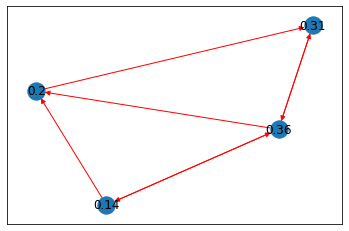

In [164]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for nodo in pr:
    G.add_node(nodo)
    

G.add_edge("A","C")
G.add_edge("C","A")
G.add_edge("A","B")
G.add_edge("C","B")
G.add_edge("B","D")
G.add_edge("C","D")
G.add_edge("D","C")

pos = nx.spring_layout(G)

labels = {}    
for node in G.nodes():
    if node in pr:
        #set the node name as the key and the label as its value 
        labels[node] = round(pr[node],2)

# Es lo mismo que pr pero redondeado        
print(labels)

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_edges(G, pos, edge_color='r', arrows = True)

plt.show()

## Referencias

- [Google Matrix](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.google_matrix.html#networkx.algorithms.link_analysis.pagerank_alg.google_matrix)
- [Código QR](https://github.com/optimizacion-2020-2-gh-classroom/practica-1-segunda-parte-graph-caroacostatovany)
- [PageRank](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html)
- [Etiquetas para los nodos](https://stackoverflow.com/questions/14665767/networkx-specific-nodes-labeling)